Step-1: Import the Necessary Dependencies

In [1]:
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,recall_score,precision_score,f1_score
import warnings
import pickle
warnings.filterwarnings("ignore")

In [3]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('project_data.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

In [4]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [7]:
df.shape

(1600000, 6)

In [9]:
#check unique target value
df.target.unique()

array([0, 4], dtype=int64)

In [10]:
#check the number of target values
df.target.nunique()

2

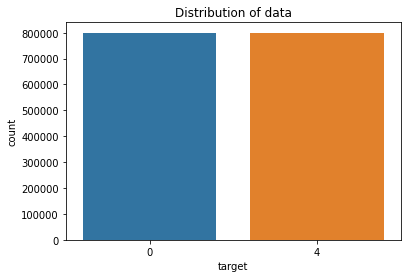

In [11]:
sns.countplot(df["target"])
plt.title("Distribution of data")
plt.show()

In [12]:
data=df[["text","target"]]

In [13]:
#replace postive 4 with 1
#note 0 - Negative 1- Positive
data["target"]=data["target"].replace(4,1)

In [14]:
data["target"].unique()

array([0, 1], dtype=int64)

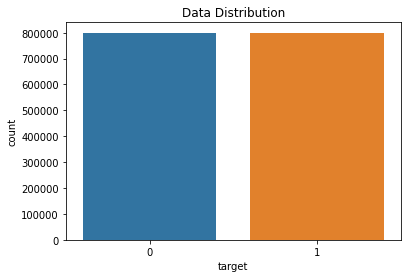

In [15]:
sns.countplot(data["target"])
plt.title("Data Distribution")
plt.show()

In [16]:
#sperate positive and negative tweet
data_neg=data[data["target"]==0]
data_pos=data[data["target"]==1]

In [17]:
#take 20000 sample from each class
positive_tweet=data_pos.iloc[:20000]
negative_tweet=data_neg.iloc[:20000]

In [18]:
#combine both class tweets
sentiments=pd.concat([positive_tweet,negative_tweet])

In [19]:
sentiments.rename(columns={"text":"tweet"},inplace=True)

In [20]:
sentiments.head()

,tweet,target
800000,I LOVE @Health4UandPets u guys r the best!!,1
800001,im meeting up with one of my besties tonight! ...,1
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
800003,Being sick can be really cheap when it hurts t...,1
800004,@LovesBrooklyn2 he has that effect on everyone,1


In [21]:
#making tweets to lower case
sentiments["tweet"]=sentiments["tweet"].str.lower()

In [22]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aaditya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aaditya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
from nltk.corpus import stopwords
english_stopwords=stopwords.words("english")

In [24]:
#clearn and remove above stopwords from tweet text
STOPWORDS=set(english_stopwords)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
sentiments["tweet"]=sentiments["tweet"].apply(lambda text: cleaning_stopwords(text))
data.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [25]:
#clearning and removing punctuations
import string
english_punctuations=string.punctuation
punctuation_list=english_punctuations
def cleaning_punctuations(text):
    translator=str.maketrans('', '',punctuation_list)
    return text.translate(translator)
sentiments["tweet"]=sentiments["tweet"].apply(lambda text: cleaning_punctuations(text))
sentiments.tail()

,tweet,target
19995,much time weekend work trip malmï¿½ frisat tod...,0
19996,one day holidays,0
19997,feeling right hate damn humprey,0
19998,geezi hv read whole book personality types emb...,0
19999,threw sign donnie bent get thingee made sad face,0


In [26]:
#cleaning and removing repeated charecters:
def clearning_repeating_char(text):
    return re.sub(r'(.)1+',r'1',text)
sentiments["tweet"]=sentiments["tweet"].apply(lambda text: clearning_repeating_char(text))
sentiments.head()

,tweet,target
800000,love health4uandpets u guys r best,1
800001,im meeting one besties tonight cant wait girl...,1
800002,darealsunisakim thanks twitter add sunisa got ...,1
800003,sick really cheap hurts much eat real food plu...,1
800004,lovesbrooklyn2 effect everyone,1


In [27]:
#cleaing and removing URL from tweet
def cleaning_url(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',text)
sentiments["tweet"]=sentiments["tweet"].apply(lambda text: cleaning_url(text))
sentiments.head()

,tweet,target
800000,love health4uandpets u guys r best,1
800001,im meeting one besties tonight cant wait girl...,1
800002,darealsunisakim thanks twitter add sunisa got ...,1
800003,sick really cheap hurts much eat real food plu...,1
800004,lovesbrooklyn2 effect everyone,1


In [28]:
#clearning and removing numeric numbers
def cleaning_numbers(text):
    return re.sub('[0-9]+', '',text)
sentiments["tweet"]=sentiments["tweet"].apply(lambda text: cleaning_numbers(text))
sentiments.head()

,tweet,target
800000,love healthuandpets u guys r best,1
800001,im meeting one besties tonight cant wait girl...,1
800002,darealsunisakim thanks twitter add sunisa got ...,1
800003,sick really cheap hurts much eat real food plu...,1
800004,lovesbrooklyn effect everyone,1


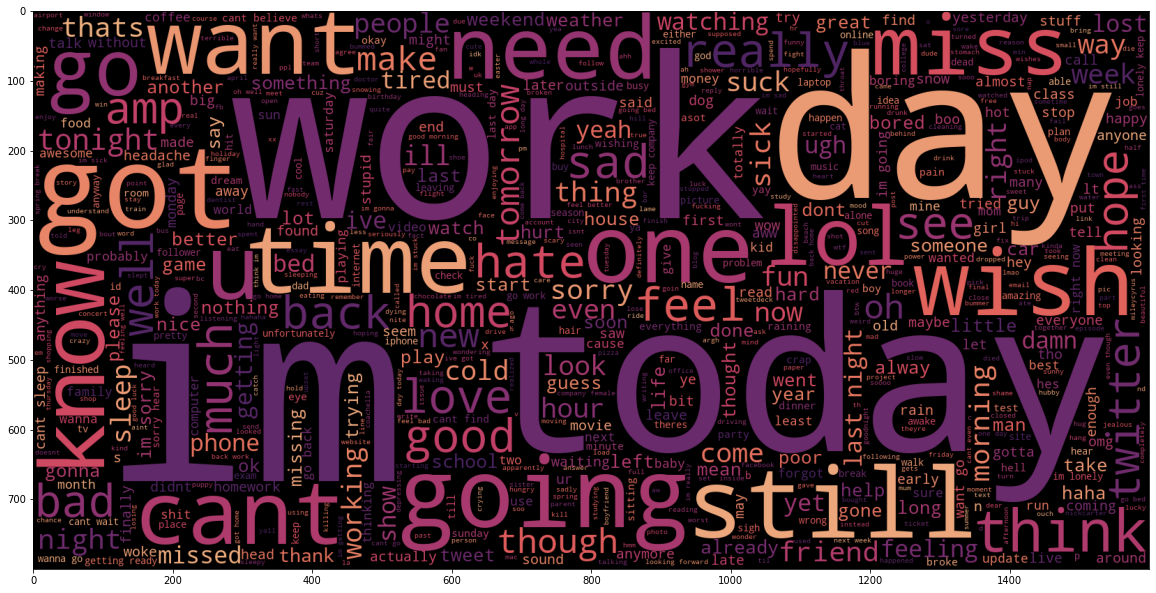

In [29]:
#plot cloud of words for negative class
negative_tweets=sentiments[sentiments["target"]==0]["tweet"]
plt.figure(figsize=(20,20))

wc= WordCloud(max_words=1000, min_font_size=10, height=800, width=1600, background_color='black', colormap='flare')\
                      .generate(' '.join(np.array(negative_tweets)))
plt.imshow(wc)
plt.show()

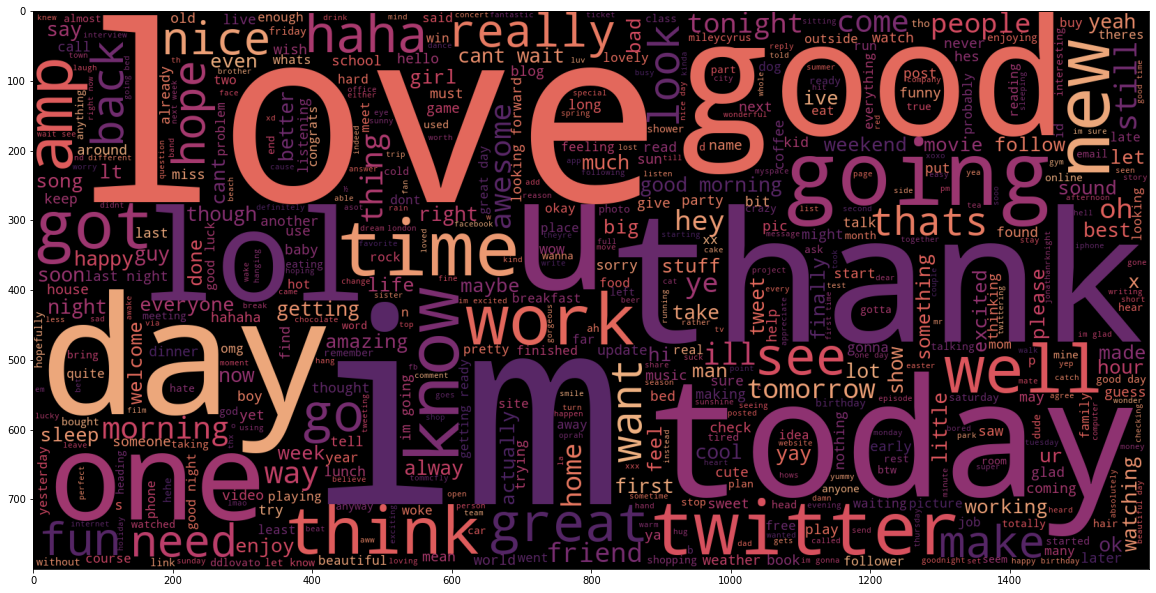

In [30]:
#plot cloud of words for positive class
positive_tweets=sentiments[sentiments["target"]==1]["tweet"]
plt.figure(figsize=(20,20))

wc= WordCloud(max_words=1000, min_font_size=10, height=800, width=1600, background_color='black', colormap='flare')\
                      .generate(' '.join(np.array(positive_tweets)))
plt.imshow(wc)
plt.show()

In [31]:
#Get Tokenization of tweet text
from nltk.tokenize import word_tokenize
sentiments["tweet"]=sentiments["tweet"].apply(word_tokenize)
sentiments.head()

,tweet,target
800000,"[love, healthuandpets, u, guys, r, best]",1
800001,"[im, meeting, one, besties, tonight, cant, wai...",1
800002,"[darealsunisakim, thanks, twitter, add, sunisa...",1
800003,"[sick, really, cheap, hurts, much, eat, real, ...",1
800004,"[lovesbrooklyn, effect, everyone]",1


In [32]:
#apply stremming
st=nltk.PorterStemmer()
def stemming_on_text(text):
    data=[st.stem(word) for word in text]
    return data
sentiments["tweet"]=sentiments["tweet"].apply(lambda text: stemming_on_text(text))
sentiments.head()

,tweet,target
800000,"[love, healthuandpet, u, guy, r, best]",1
800001,"[im, meet, one, besti, tonight, cant, wait, gi...",1
800002,"[darealsunisakim, thank, twitter, add, sunisa,...",1
800003,"[sick, realli, cheap, hurt, much, eat, real, f...",1
800004,"[lovesbrooklyn, effect, everyon]",1


In [33]:
#apply lemmatizer
nltk.download('wordnet')
lm=nltk.WordNetLemmatizer()
def lemmatizer_on_word(text):
    data=[lm.lemmatize(word) for word in text]
    return data
sentiments["tweet"]=sentiments["tweet"].apply(lambda text:lemmatizer_on_word(text))
sentiments.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aaditya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,tweet,target
800000,"[love, healthuandpet, u, guy, r, best]",1
800001,"[im, meet, one, besti, tonight, cant, wait, gi...",1
800002,"[darealsunisakim, thank, twitter, add, sunisa,...",1
800003,"[sick, realli, cheap, hurt, much, eat, real, f...",1
800004,"[lovesbrooklyn, effect, everyon]",1


In [34]:
#removing comma and making tweet from list to string format.
sentiments["tweet"]=[" ".join(line)for line in sentiments["tweet"]]

In [35]:
#spliting data into train and test subsets
x_train,x_test,y_train,y_test=train_test_split(sentiments["tweet"].to_numpy(),sentiments["target"].to_numpy(),test_size=0.1,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((36000,), (4000,), (36000,), (4000,))

# Model Building

Model 1: Logistic Regssion

In [36]:
logit_model = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("logistic", LogisticRegression()) # model the text
])

In [37]:
logit_model.fit(x_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('logistic', LogisticRegression())])

In [39]:
#create model evaluation function
def model_evaluate(model,test_data):
    y_pred=model.predict(test_data)
    print("Training Score : ",model.score(x_train,y_train))
    print("validation Score : ",accuracy_score(y_test,y_pred))
    print("Precision Score : ",precision_score(y_test,y_pred))
    print("Recall Score : ",precision_score(y_test,y_pred))
    print("F1 Score : ",f1_score(y_test,y_pred))
    print("="*100)
    print("Classification Report : ",classification_report(y_test,y_pred))
    print("="*100)
    cm=confusion_matrix(y_test,y_pred)
    print(cm)

In [40]:
#Evaluate Logistic Regression Model
model_evaluate(logit_model,x_test)

Training Score :  0.8384166666666667
validation Score :  0.74825
Precision Score :  0.7438905180840665
Recall Score :  0.7438905180840665
F1 Score :  0.7514194026166378
Classification Report :                precision    recall  f1-score   support

           0       0.75      0.74      0.74      1995
           1       0.74      0.76      0.75      2005

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000

[[1471  524]
 [ 483 1522]]


Model 2 : BernoulliNB 

In [41]:
nb_model=Pipeline([
        ("tfidf",TfidfVectorizer()),
        ("bernominal",BernoulliNB())
])

In [42]:
nb_model.fit(x_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('bernominal', BernoulliNB())])

In [43]:
#Evaluate Bernomial Model
model_evaluate(nb_model,x_test)

Training Score :  0.8799166666666667
validation Score :  0.73875
Precision Score :  0.7620087336244541
Recall Score :  0.7620087336244541
F1 Score :  0.7276518113109199
Classification Report :                precision    recall  f1-score   support

           0       0.72      0.78      0.75      1995
           1       0.76      0.70      0.73      2005

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000

[[1559  436]
 [ 609 1396]]


Model 3: LinearSVC

In [44]:
linear_svc=Pipeline([
        ("tfidf",TfidfVectorizer()),
        ("bernominal",LinearSVC())
])

In [45]:
linear_svc.fit(x_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('bernominal', LinearSVC())])

In [46]:
model_evaluate(linear_svc,x_test)

Training Score :  0.9447222222222222
validation Score :  0.73025
Precision Score :  0.7289812067260139
Recall Score :  0.7289812067260139
F1 Score :  0.7320586044201639
Classification Report :                precision    recall  f1-score   support

           0       0.73      0.73      0.73      1995
           1       0.73      0.74      0.73      2005

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000

[[1447  548]
 [ 531 1474]]


# saving model for integration with web application

In [47]:
file=open("twitter_model.pkl","wb")
pickle.dump(logit_model,file)
file.close()